In [1]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys

## Webcam 동영상 열기

In [ ]:
# 카메라 열기
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

if not cap.isOpened(): #True or Falose
    print("Camera open failed")
    cap.release()
    sys.exit()


# 카메라 프레임 크기 출력
print('Frame width:', int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
print('Frame height:', int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

# 카메라 프레임 처리
while True:
    ret, frame = cap.read()

    if not ret:
        
        break

    edge = cv2.Canny(frame, 50, 150)       
    #inversed = ~frame  # 반전 (255 - 원래 값) : 밝은 영역은 어두워지고, 어두운 영역은 밝아지는 시각적 효과.
    
    cv2.imshow('frame', frame)
    cv2.imshow('frame1', edge)
    #cv2.imshow('inversed', inversed)

    if cv2.waitKey(10) == 27:
        break

cap.release()
cv2.destroyAllWindows()

Frame width: 640
Frame height: 480


## OpenCV DNN 얼굴검출 : SSD
-  https://github.com/spmallick/learnopencv/tree/master/AgeGender
-  SSD(Single Shot MultiBox Detector): 
    - 다양한 크기의 앵커 박스를 사용하여 이미지를 한 번에 처리하고 여러 객체를 탐지합니다.


In [4]:
import numpy as np
import sys
import cv2
import pandas as pd

# img = cv2.imread('./images/sunglass.png')
img = cv2.imread('./images/king_face.png')

if img is None:
    print('image read failed')
    sys.exit()

# SSD Face detector tensorflow model   
model = 'opencv_face_detector_uint8.pb'
config = 'opencv_face_detector.pbtxt'

face_net = cv2.dnn.readNet(model, config)
# face_net.getLayerNames()

if face_net.empty():
    print('Net open failed')
    sys.exit()

# blobFromImage(image[, scalefactor[, size[, mean[, swapRB[, crop[, ddepth]]]]]]) -> retval
blob = cv2.dnn.blobFromImage(img, 1, (300, 300), (104, 177, 123),
                            swapRB=False)

face_net.setInput(blob)
out = face_net.forward()

labels = ["img_id", "is_face", "confidence", "left", "top", "right", "bottom"]
out_df = pd.DataFrame(out[0][0], columns = labels)
print(out_df)

detect = out[0, 0, :, :]
h, w = img.shape[:2]

for i in range(detect.shape[0]):
    confidence = detect[i, 2] # (0, 1, confidence, x1, y1, x2, y2)
    
    if confidence > 0.15:
        # out matrix에서 x1, y1, x2, y2 값이 0 ~1로 normalize 되어 있음
        
        x1 = int(detect[i, 3]*w)
        y1 = int(detect[i, 4]*h)
        x2 = int(detect[i, 5]*w)
        y2 = int(detect[i, 6]*h)
        
        cv2.rectangle(img, (x1, y1), (x2, y2),
                     (0, 0, 255))
        
        text = 'Face: {}%'.format(round(confidence*100, 2))
        cv2.putText(img, text, (x1, y1-1), cv2.FONT_HERSHEY_SIMPLEX,
                   0.8, (0, 0, 255), 1, cv2.LINE_AA)

cv2.imshow('image', img)

while True:
    if cv2.waitKey() == 27:
        break

cv2.destroyAllWindows()

     img_id  is_face  confidence      left       top     right    bottom
0       0.0      1.0    0.989431  0.825202  0.502988  0.893821  0.658601
1       0.0      1.0    0.950553  0.147596  0.511079  0.215222  0.681570
2       0.0      1.0    0.947276  0.288199  0.444965  0.359195  0.628823
3       0.0      1.0    0.920967  0.499137  0.392986  0.589955  0.570557
4       0.0      1.0    0.835135  0.642767  0.463616  0.720524  0.659535
..      ...      ...         ...       ...       ...       ...       ...
195     0.0      0.0    0.000000  0.000000  0.000000  0.000000  0.000000
196     0.0      0.0    0.000000  0.000000  0.000000  0.000000  0.000000
197     0.0      0.0    0.000000  0.000000  0.000000  0.000000  0.000000
198     0.0      0.0    0.000000  0.000000  0.000000  0.000000  0.000000
199     0.0      0.0    0.000000  0.000000  0.000000  0.000000  0.000000

[200 rows x 7 columns]


## OpenCV DNN webcam 얼굴검출

In [5]:
import sys
import numpy as np
import cv2

## SSD Face detector tensorflow model   
model = 'opencv_face_detector_uint8.pb'
config = 'opencv_face_detector.pbtxt'


cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print('Camera open failed!')
    sys.exit()

net = cv2.dnn.readNet(model, config)

if net.empty():
    print('Net open failed!')
    sys.exit()

while True:
    ret, frame = cap.read()

    if not ret:
        break

    blob = cv2.dnn.blobFromImage(frame, 1, (300, 300), (104, 177, 123))
    net.setInput(blob)
    out = net.forward()# out.shape=(1,1, 200, 7)
    
        
    detect = out[0, 0, :, :] ##0, 0, 사용안함
    (h, w) = frame.shape[:2]

    for i in range(detect.shape[0]):
        confidence = detect[i, 2]

        if confidence > 0.5:
           
            # out matrix에서 x1, y1, x2, y2 값이 0 ~1로 normalize 되어 있음
            x1 = int(detect[i, 3] * w)
            y1 = int(detect[i, 4] * h)
            x2 = int(detect[i, 5] * w)
            y2 = int(detect[i, 6] * h)

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0))

            label = f'Face: {confidence:4.2f}'
            cv2.putText(frame, label, (x1, y1 - 1), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.8, (0, 255, 0), 1, cv2.LINE_AA)

    cv2.imshow('frame', frame)

    if cv2.waitKey(1) == 27:
        break

        
cap.release()
cv2.destroyAllWindows()

## Yolo v3 객체검출 with opencv dnn

- YOLO(You Only Look Once) 
    - 이미지를 그리드로 나누고, 각 그리드 셀에서 객체의 존재와 위치를 한 번에 예측하는 실시간 객체 탐지 방법입니다.

- 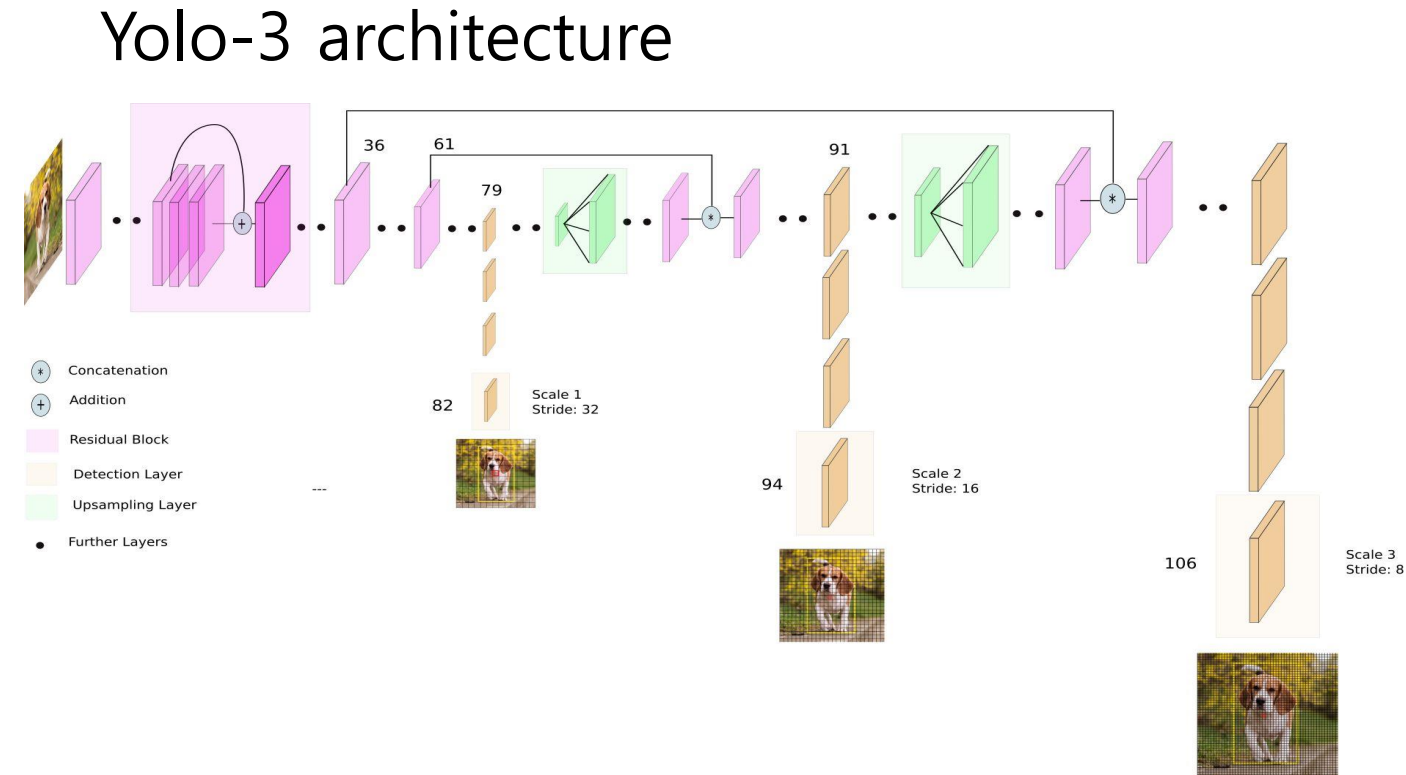

- https://pjreddie.com/darknet/yolo/

- NMSBoxes(bboxes, scores, score_threshold, nms_threshold) -> indices
- nms_threshold: nms_threshold a threshold used in non maximum suppression

- getPerfProfile() -> retval, timings
    @brief Returns overall time for inference and timings (in ticks) for layers.

- https://github.com/pjreddie/darknet/blob/master/data/coco.names


In [ ]:
import sys
import numpy as np
import cv2

# [1] 모델 및 설정 파일 경로 지정
model = './model/yolov3.weights'
config = './model/yolov3.cfg'
class_labels = './model/coco.names'

# [2] 테스트할 이미지 파일 목록 정의
img_files = ['./images/dog.jpg', 
             './images/person.jpg', 
             './images/sheep.jpg', 
             './images/kite.jpg']

# [3] 이미지 파일이 없을 경우 종료
if img_files is None:
    print('Image read failed')
    sys.exit()

# [4] 네트워크 모델 로드
net = cv2.dnn.readNet(model, config)

# [5] 모델 로드 실패 시 종료
if net.empty():
    print('Net open failed!')
    sys.exit()

# [6] 클래스 이름 리스트 로드
classes = []
with open(class_labels, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# [7] 출력 레이어 이름 추출
layer_names = net.getLayerNames()  # 전체 네트워크 레이어들의 이름 리스트
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]   # net.getUnconnectedOutLayers() : 최종 출력값을 제공하는 레이어들의 인덱스 번호를 반환(1부터 시작하는 인덱스반환)
print(output_layers)  # ['yolo_82': 13*13, 'yolo_94':26*26, 'yolo_106':52*52 해상도도] 등

# [8] confidence threshold 및 NMS threshold 설정
confThreshold = 0.5  # 객체로 인식할 최소 확신값
nmsThreshold = 0.4   # 박스 겹침 제거 기준

# [9] 이미지 파일 반복 처리
for i in img_files:
    img = cv2.imread(i)

    if img is None:
        continue

    # [10] 이미지 → 블롭(blob)으로 변환 후 입력 설정
    blob = cv2.dnn.blobFromImage(img, 1/255., (320, 320), swapRB=True)
    net.setInput(blob)

    # [11] 추론 수행
    outs = net.forward(output_layers)

    # [12] 출력값 후처리 (confidence, class_id 추출)
    h, w = img.shape[:2]
    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]  # 클래스별 확률 값
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > confThreshold:
                # [13] 바운딩 박스 좌표 계산
                cx = int(detection[0] * w)
                cy = int(detection[1] * h)
                bw = int(detection[2] * w)
                bh = int(detection[3] * h)
                sx = int(cx - bw / 2)
                sy = int(cy - bh / 2)

                boxes.append([sx, sy, bw, bh])
                confidences.append(float(confidence))
                class_ids.append(int(class_id))

    # [14] 비최대 억제(NMS)로 겹치는 박스 제거
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)

    # [15] 최종 검출 결과 이미지에 출력
    for i in indices:
        # i = i[0]  # OpenCV 버전에 따라 필요할 수 있음
        sx, sy, bw, bh = boxes[i]
        label = f'{classes[class_ids[i]]}: {confidences[i]:.2}'
        color = (0, 0, 255)  # 빨간색 박스
        cv2.rectangle(img, (sx, sy, bw, bh), color, 2)
        cv2.putText(img, label, (sx, sy - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)

    # [16] 추론 시간 표시
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
    cv2.putText(img, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 1, cv2.LINE_AA)

    # [17] 결과 이미지 표시
    cv2.namedWindow('img', cv2.WINDOW_NORMAL)
    cv2.imshow('img', img)
    cv2.waitKey()

# [18] 모든 창 닫기
cv2.destroyAllWindows()


['yolo_82', 'yolo_94', 'yolo_106']


## Yolo v10 객체검출 with pytorch

In [ ]:
from ultralytics import YOLO

## coco dataset
classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
              "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
              "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
              "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
              "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
              "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
              "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
              "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
              "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush"
              ]
print(len(classNames))

80


In [ ]:
cap = cv2.VideoCapture("../fig/object_detection/vtest.avi")
# cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
# cap.set(cv2.CAP_PROP_FPS, 30)

if not cap.isOpened():
    print("camera open failed")
    sys.exit()

# model = YOLO("yolov3.pt")  # load a pretrained model (recommended for training)
model = YOLO("yolov10m.pt")  # load a pretrained model (recommended for training)

CONFIDENCE_THRESHOLD = 0.6

# with open('./yolov8_pretrained/coco128.txt', 'r') as f:
#     data = f.read()
#     class_list = data.split('\n')

tm = cv2.TickMeter()

while True:
    tm.reset()
    tm.start()
    
    ret, frame = cap.read()

    if not ret:
        print('frame read failed')
        break
    
    detection = model(frame, verbose=False)[0]

    for data in detection.boxes.data.tolist():
        confidence = data[4]
        if confidence < CONFIDENCE_THRESHOLD:
            continue
        
        xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
        label = int(data[5])
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(frame, classNames[label]+ ' ' +str(round(confidence, 2))+'%', 
        (xmin, ymin), cv2.FONT_ITALIC, 0.5, (255, 255, 255), 1)

        tm.stop()

        total = tm.getTimeMilli()

        fps = f'FPS: {1 / total:.4f}'
        cv2.putText(frame, fps, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1)
        cv2.imshow('frame', frame)

    if cv2.waitKey(20) == 27:
        break

cap.release()
cv2.destroyAllWindows()

100%|██████████| 32.1M/32.1M [00:02<00:00, 12.4MB/s]
